<a href="https://colab.research.google.com/github/yoon777/cv_project/blob/main/data_load.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 라이브러리 설정

In [1]:
!sudo apt install tesseract-ocr
!sudo apt-get install tesseract-ocr-kor
!pip install pytesseract
!pip install PyPDF2
!pip install easyocr
!pip install pdfplumber
!pip install tabula-py
!pip install camelot-py[cv]
!pip install PyPDF2==2.10.5
!sudo apt-get install ghostscript

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 49 not upgraded.
Need to get 4,816 kB of archives.
After this operation, 15.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1.1 [1,591 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-osd all 1:4.00~git30-7274cfa-1.1 [2,990 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr amd64 4.1.1-2.1build1 [236 kB]
Fetched 4,816 kB in 2s (2,867 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debc

In [2]:
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import os
import cv2
from tqdm import tqdm
import pytesseract
import PyPDF2
import pdfplumber

## 데이터 경로 설정

In [4]:
# 구글 드라이브
from google.colab import drive
drive.mount('/content/drive')
image_dir = '/content/drive/MyDrive/CV_project/train_raw'

Mounted at /content/drive


In [ ]:
# # vscode
# image_dir = 'C:/Users/Yoon/Yoon/2024/BITAMIN/2nd_session/CV_project/032.표_이미지-텍스트_쌍_데이터/조합표/train_raw'

## 이미지 불러오기

6066
/content/drive/MyDrive/CV_project/train_raw/T02_C01_61002_1589_060.jpg


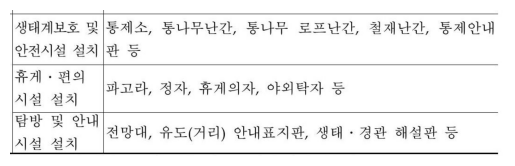

In [ ]:
# 이미지 파일 리스트 불러오기
image_files = [f for f in os.listdir(image_dir) if f.startswith('T02_C01') and f.endswith('.jpg')]

print(len(image_files))

# 첫 번째 이미지 불러오기
first_image_path = os.path.join(image_dir, image_files[0])
print(first_image_path)
image = Image.open(first_image_path)

# 이미지 출력
plt.imshow(image)
plt.axis('off')  # 축 숨기기
plt.show()

## EASYOCR

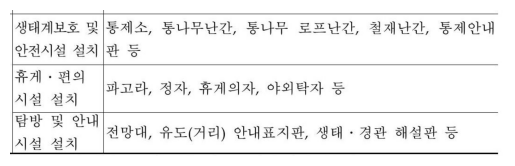

                                     text  xmin  xmax  ymin  ymax
0                           (생태계보호 및 통제소,     5   303    17    61
1                                  통나무난간    319   483    19    61
2                                     통나무   499   597    19    61
3                                  로프난간 ,   612   744    23    61
4                                  철재난간 ,   757   895    21    61
5                                    통제안내   909  1037    19    61
6                         (안전시설 설치 |판   등     4   283    66   110
7                                 휴게 . 편의     9   163   125   165
8               파고라   정자   휴게 의자  야외탁자  등   201   717   146   189
9                                 시설   설치     5   149   173   213
10                              담방   및 안내     7   193   217   257
11  전망대 ,  유도(거리) 안내표지판   생태 . 경관   해설판 등   199   959   240   285
12                                  시설 설치     7   149   269   305


In [ ]:
import easyocr
import pandas as pd

# 이미지 읽기
img_path = os.path.join(image_dir, image_files[0])  # 첫 번째 이미지 선택
img = Image.open(img_path)  # PIL 이미지로 열기

# 이미지 출력 (원본 이미지 시각화)
plt.imshow(img)
plt.axis('off')  # 축 숨기기
plt.show()

# OCR 모델 초기화 (한국어 및 영어 지원)
reader = easyocr.Reader(['ko', 'en'])

# 이미지에서 텍스트 및 좌표 추출
results = reader.readtext(img)

# 좌표와 텍스트를 데이터프레임으로 변환
data = []
grid = []
for (bbox, text, confidence) in results:
    # bbox는 좌표 정보, text는 인식된 텍스트
    (top_left, top_right, bottom_right, bottom_left) = bbox
    xmin = min(top_left[0], bottom_left[0])
    xmax = max(top_right[0], bottom_right[0])
    ymin = min(top_left[1], top_right[1])
    ymax = max(bottom_left[1], bottom_right[1])

    # 좌표와 텍스트 정보를 저장
    data.append(text)
    grid.append({
        'xmin': xmin,
        'xmax': xmax,
        'ymin': ymin,
        'ymax': ymax
    })

df = pd.DataFrame(data)
print(df)

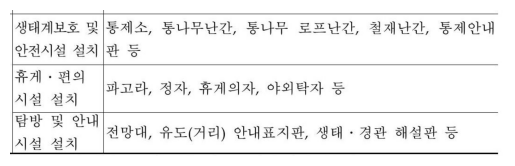

In [ ]:
# 이미지 출력
plt.imshow(img)
plt.axis('off')  # 축 숨기기
plt.show()

## 딥러닝..? 잘 모르겠음

In [ ]:
## 2. 딥러닝 모델 준비
import torch
import torchvision.transforms as transforms
from torchvision import models
from PIL import Image
import requests

# ResNet 모델 불러오기 (사전 학습된 모델 사용)
model = models.resnet50(pretrained=True)
model.eval()  # 평가 모드로 전환

# 이미지 전처리
preprocess = transforms.Compose([
  transforms.Resize(256),
  transforms.CenterCrop(224),
  transforms.ToTensor(),
  transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# 이미지 로드
img_path = os.path.join(image_dir, image_files[0])  # 첫 번째 이미지 선택
img = Image.open(img_path)  # PIL 이미지로 열기
img_t = preprocess(img)
batch_t = torch.unsqueeze(img_t, 0)

# 이미지 예측
with torch.no_grad():
  output = model(batch_t)

# ImageNet 클래스 이름 로드
# URL에서 ImageNet 클래스 레이블 다운로드
url = "https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt"
response = requests.get(url)

# 텍스트 데이터를 라인별로 리스트에 저장
labels = [line.strip() for line in response.text.splitlines()]

# 결과에서 가장 높은 확률의 클래스 가져오기
_, index = torch.max(output, 1)
percentage = torch.nn.functional.softmax(output, dim=1)[0] * 100
print(f"Predicted: {labels[index[0]]}, Confidence: {percentage[index[0]].item()}%")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Predicted: screw, Confidence: 15.570100784301758%


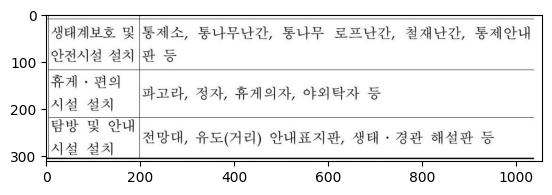

In [ ]:
import torch
import torchvision
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms as T
import matplotlib.patches as patches

# Pre-trained Faster R-CNN 모델 로드 (최신 가중치 사용)
from torchvision.models.detection import FasterRCNN_ResNet50_FPN_Weights
weights = FasterRCNN_ResNet50_FPN_Weights.DEFAULT
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=weights)
model.eval()

# 이미지 불러오기 및 전처리 (크기 조정 포함)
image = Image.open(img_path)
transform = T.Compose([T.Resize((800, 600)), T.ToTensor()])
img = transform(image)

# 이미지에서 객체 탐지
with torch.no_grad():
    prediction = model([img])

# 점수 임계값 설정 (탐지된 객체 필터링)
threshold = 0.2
boxes = prediction[0]['boxes']
labels = prediction[0]['labels']
scores = prediction[0]['scores']

# 임계값보다 큰 점수에 대해 필터링
filtered_boxes = boxes[scores > threshold]
filtered_labels = labels[scores > threshold]
filtered_scores = scores[scores > threshold]

# 탐지된 객체 시각화
fig, ax = plt.subplots(1)
ax.imshow(image)

# 필터된 결과를 시각화
for i in range(len(filtered_boxes)):
    box = filtered_boxes[i]
    rect = patches.Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1], linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

plt.show()

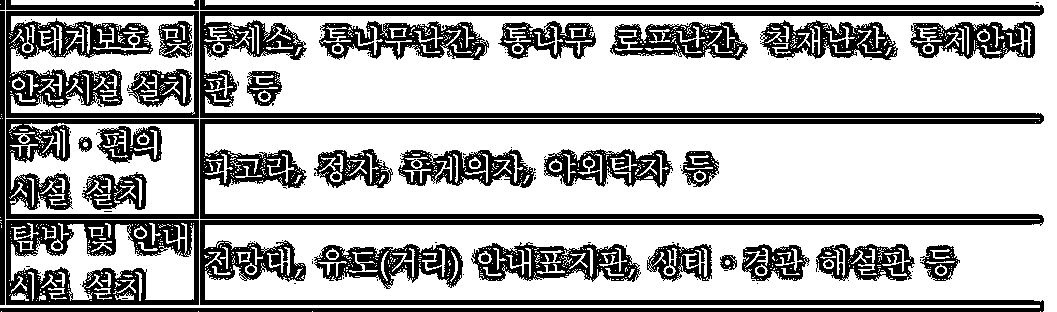

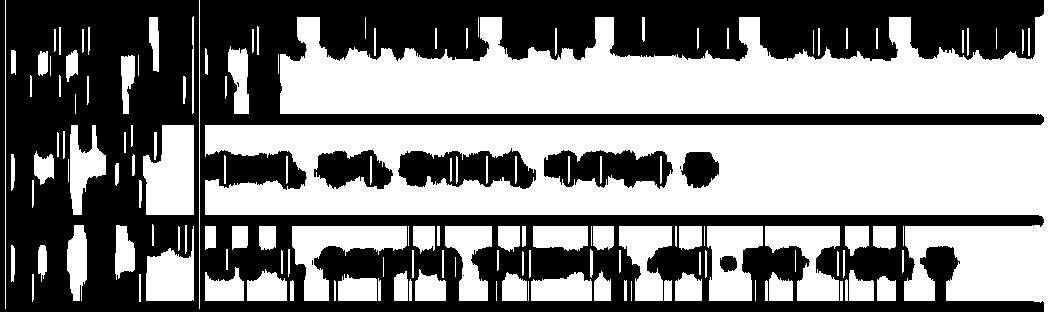

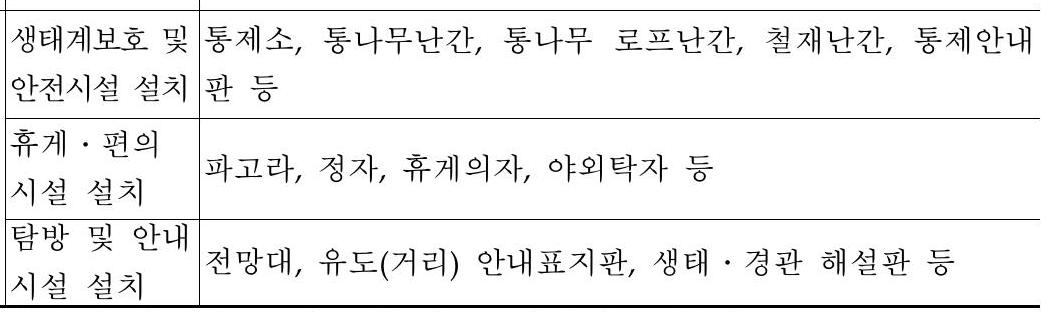

In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow  # Colab에서 이미지를 표시하기 위한 패치

# 이미지 파일 경로 및 전처리 옵션 설정
process_background = False  # 배경 처리 여부 (True 또는 False로 설정)
blocksize = 11  # Adaptive Threshold에서 사용되는 blocksize 값
c = 2  # Adaptive Threshold에서 사용되는 상수 값
line_scale = 15  # 세로 또는 가로선 크기 조정용 스케일
direction = "vertical"  # 방향 설정: 'vertical' 또는 'horizontal'
regions = None  # 특정 영역이 있다면 [(x, y, w, h), ...] 형태로 입력
iterations = 2  # 팽창(dilation) 반복 횟수

# 이미지 읽기
img = cv2.imread(img_path)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# 배경 처리에 따른 이진화
if process_background:
    threshold = cv2.adaptiveThreshold(
        gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, blocksize, c
    )
else:
    threshold = cv2.adaptiveThreshold(
        np.invert(gray),
        255,
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY,
        blocksize,
        c,
    )

# 중간 결과 출력: 이진화 이미지
cv2_imshow(threshold)  # Colab에서 이진화된 이미지를 표시
cv2.waitKey(0)

# 세로 또는 가로 방향에 맞는 구조화 요소 설정
if direction == "vertical":
    size = threshold.shape[0] // line_scale
    el = cv2.getStructuringElement(cv2.MORPH_RECT, (1, size))
elif direction == "horizontal":
    size = threshold.shape[1] // line_scale
    el = cv2.getStructuringElement(cv2.MORPH_RECT, (size, 1))
else:
    raise ValueError("Specify direction as either 'vertical' or 'horizontal'")

# 특정 영역만 처리할 경우
if regions is not None:
    region_mask = np.zeros(threshold.shape)
    for region in regions:
        x, y, w, h = region
        region_mask[y : y + h, x : x + w] = 1
    threshold = np.multiply(threshold, region_mask)

# 팽창과 침식으로 선을 감지
threshold = cv2.erode(threshold, el)
threshold = cv2.dilate(threshold, el)
dmask = cv2.dilate(threshold, el, iterations=iterations)

# 중간 결과 출력: 침식 및 팽창 처리 후 이미지
cv2_imshow(threshold)  # Colab에서 처리된 이미지를 표시
cv2.waitKey(0)

# 테이블 외곽선 검출
contours, _ = cv2.findContours(
    threshold.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
)

# 테이블 좌표 추출
lines = []
for c in contours:
    x, y, w, h = cv2.boundingRect(c)
    if direction == "vertical":
        lines.append(((x + x + w) // 2, y + h, (x + x + w) // 2, y))
    elif direction == "horizontal":
        lines.append((x, (y + y + h) // 2, x + w, (y + y + h) // 2))

# 세로선과 가로선이 교차하는 곳 탐지
vertical = np.zeros_like(threshold)
horizontal = np.zeros_like(threshold)
mask = vertical + horizontal
contours = sorted(contours, key=cv2.contourArea, reverse=True)[:10]

# 교차점 및 테이블 셀 정보 추출
joints = np.multiply(vertical, horizontal)
tables = {}
for c in contours:
    x, y, w, h = cv2.boundingRect(c)
    roi = joints[y : y + h, x : x + w]
    jc, _ = cv2.findContours(roi.astype(np.uint8), cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
    if len(jc) <= 4:
        continue
    joint_coords = [(x + (2 * jx + jw) // 2, y + (2 * jy + jh) // 2) for j in jc]
    tables[(x, y + h, x + w, y)] = joint_coords

# 최종 결과 이미지에 테이블 외곽선 표시
for table_coords, joints in tables.items():
    x1, y1, x2, y2 = table_coords
    cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)  # 테이블 외곽선
    for joint in joints:
        cv2.circle(img, joint, 3, (255, 0, 0), -1)  # 조인트 포인트

# 중간 결과 출력: 최종 이미지
cv2_imshow(img)  # Colab에서 최종 이미지를 표시
cv2.waitKey(0)
cv2.destroyAllWindows()

## EASYOCR 왠지 이미지가 선명해진듯?

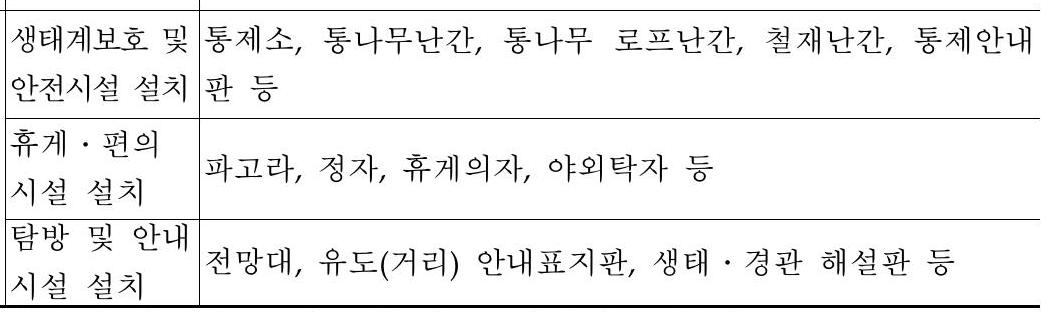

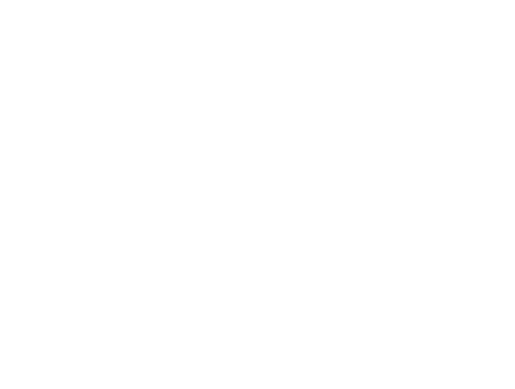

                                     text  xmin  xmax  ymin  ymax
0                           (생태계보호 및 통제소,     5   303    17    61
1                                  통나무난간    319   483    19    61
2                                     통나무   499   597    19    61
3                                  로프난간 ,   612   744    23    61
4                                  철재난간 ,   757   895    21    61
5                                    통제안내   909  1037    19    61
6                         (안전시설 설치 |판   등     4   283    66   110
7                                 휴게 . 편의     9   163   125   165
8               파고라   정자   휴게 의자  야외탁자  등   201   717   146   189
9                                 시설   설치     5   149   173   213
10                              담방   및 안내     7   193   217   257
11  전망대 ,  유도(거리) 안내표지판   생태 . 경관   해설판 등   199   959   240   285
12                                  시설 설치     7   149   269   305


In [ ]:
import easyocr
import pandas as pd

# 이미지 출력 (원본 이미지 시각화)
cv2_imshow(img)
plt.axis('off')  # 축 숨기기
plt.show()

# OCR 모델 초기화 (한국어 및 영어 지원)
reader = easyocr.Reader(['ko', 'en'])

# 이미지에서 텍스트 및 좌표 추출
results = reader.readtext(img)

# 좌표와 텍스트를 데이터프레임으로 변환
data = []
for (bbox, text, confidence) in results:
    # bbox는 좌표 정보, text는 인식된 텍스트
    (top_left, top_right, bottom_right, bottom_left) = bbox
    xmin = min(top_left[0], bottom_left[0])
    xmax = max(top_right[0], bottom_right[0])
    ymin = min(top_left[1], top_right[1])
    ymax = max(bottom_left[1], bottom_right[1])

    # 좌표와 텍스트 정보를 저장
    data.append({
        'text': text,
        'xmin': xmin,
        'xmax': xmax,
        'ymin': ymin,
        'ymax': ymax
    })

df = pd.DataFrame(data)
print(df)

## DLA + OCR

In [13]:
import pdfplumber

# PDF 파일 열기
with pdfplumber.open("기계학습 2조 5주차 조별보고서.pdf") as pdf:
  for page in pdf.pages:
    # 레이아웃 분석: 텍스트, 이미지, 표 구분
    print("페이지 번호:", page.page_number)
    print("텍스트:")
    print(page.extract_text())
    if page.images:
      print("이미지:", page.images)
    if page.extract_tables():
      print("테이블:", page.extract_tables())

페이지 번호: 1
텍스트:
5주차 조별보고서 (2조)
작성일: 2024년 9월 29일 작성자: 김윤영
조 모임 일시: 2024년 9월 28일 모임장소: 온라인 미팅 (구글 미트)
참석자: 김수연, 김윤영, 김재령, 문서영, 조유진
조원: 김수연, 김윤영, 김재령, 문서영, 전혜진, 조유진
구 분 내 용
학습 범위와 내용
(조별 모임 전에 조장이 1. 강의자료 chap2-3 (p.45-57)
공지)
Q1. 목적함수는 머신러닝 모델을 측정하는 방법 중 하나이고, 각 문제 별로 다른 달성 목표 별로 최대화
논의 내용 를 해야 하는 경우도 있을 것 같습니다. 일반적으로는 목적함수를 최소화하는 방향으로 설정하나요?
(모임 전 공지된 개별 학습 A1. 최대화 목적함수는 강화학습에서 주로 사용된다. (행동을 취할 때 마다 보상이 주어지고 이러한 보
범위에서 이해된 것과 상을 최대화하는 방향으로 학습)
못한 것들 )
테이블: [[['5주차 조별보고서 (2조)', None, None], ['작성일: 2024년 9월 29일', None, '작성자: 김윤영'], ['조 모임 일시: 2024년 9월 28일', None, '모임장소: 온라인 미팅 (구글 미트)'], ['참석자: 김수연, 김윤영, 김재령, 문서영, 조유진', None, '조원: 김수연, 김윤영, 김재령, 문서영, 전혜진, 조유진'], ['구 분', '내 용', None], ['학습 범위와 내용\n(조별 모임 전에 조장이\n공지)', '1. 강의자료 chap2-3 (p.45-57)', None], ['논의 내용\n(모임 전 공지된 개별 학습\n범위에서 이해된 것과\n못한 것들 )', 'Q1. 목적함수는 머신러닝 모델을 측정하는 방법 중 하나이고, 각 문제 별로 다른 달성 목표 별로 최대화\n를 해야 하는 경우도 있을 것 같습니다. 일반적으로는 목적함수를 최소화하는 방향으로 설정하나요?\nA1. 최대화 목적함수는 강화학습에서 주로 사용된다. (행동을 취할 때 마다 보상이 주어지고 이러한 보\n상을 최대화하는 방향으로 학습

In [6]:
import pytesseract
from PIL import Image

# 이미지 파일 로드
image = Image.open("T02_C01_63003_1706_290.jpg")

# OCR 수행
text = pytesseract.image_to_string(image, lang='kor+eng')

# 추출된 텍스트 출력
print("추출된 텍스트:")
print(text)

추출된 텍스트:
 

 

 

 

농어촌특별세
지방제분) | 저방세과세대상에 부과 및 감면에 부과되므로 지방세로 이양
- BEA 취득, 보유, 처분까지 세원관리 일원호   부동.
er     A aa     fr     }지 세원관리 일원화로 부동산 세
(부동잔 관련) ｜- 소득과세로서 지방세의 재산과세 비중 완화
- 취득세, 재산세와 연계하여 징수을 제고 가능
- a Il 대상 중 지역성이 강한 특정장소의 입장행위와
개별소비세    흥음식행위에 대하여 지방이양
(특정 유흥 및 ㅣ 고기 대상이 지역에 정착되어 있기 때문에 지방세 보편성
시설 입장 관련) | Soa ee
- 현행 개별소비세 과세체계를 유지함으로써 납세자 혼란 및 추7
용 발생이 없음.

 

 

 



In [15]:
import tabula

# PDF에서 테이블 추출
tables = tabula.read_pdf("기계학습 2조 5주차 조별보고서.pdf", pages="all", multiple_tables=True, guess=False)

# 추출된 테이블 개수 및 첫 번째 테이블 확인
print(f"총 {len(tables)}개의 테이블이 발견되었습니다.")
print("첫 번째 테이블:")
print(tables[0])

# 테이블을 CSV로 저장
tabula.convert_into("기계학습 2조 5주차 조별보고서.pdf", "table1.csv", output_format="csv", pages="all")

총 28개의 테이블이 발견되었습니다.
첫 번째 테이블:
        Unnamed: 0 Unnamed: 1 Unnamed: 2     Unnamed: 3 Unnamed: 4 Unnamed: 5  \
0    작성일: 2024년 9월        29일        NaN            NaN        NaN        NaN   
1   조 모임 일시: 2024년         9월        NaN            28일        NaN        NaN   
2   참석자: 김수연, 김윤영,        NaN       김재령,           문서영,        조유진        NaN   
3              NaN        NaN        NaN            NaN        NaN        NaN   
4              구 분        NaN        NaN            NaN        NaN        NaN   
5        학습 범위와 내용        NaN        NaN            NaN        NaN        NaN   
6    (조별 모임 전에 조장이        NaN        NaN        1. 강의자료    chap2-3        NaN   
7              공지)        NaN        NaN            NaN        NaN        NaN   
8              NaN        NaN        NaN      Q1. 목적함수는        NaN       머신러닝   
9            논의 내용        NaN        NaN        를 해야 하는        경우도         있을   
10    (모임 전 공지된 개별         학습        NaN  A1. 최대화 목적함수는        NaN        NaN 

In [18]:
import camelot

# PDF에서 테이블 추출
tables = camelot.read_pdf("기계학습 2조 5주차 조별보고서.pdf", pages="all")

# 추출된 테이블 개수 및 첫 번째 테이블 확인
print(f"총 {len(tables)}개의 테이블이 발견되었습니다.")
if tables:
  print("첫 번째 테이블:")
  print(tables[0].df)

총 28개의 테이블이 발견되었습니다.
첫 번째 테이블:
                                                   0  \
0                                   5주차  조별보고서  (2조)   
1                             작성일:    2024년  9월  29일   
2                       조  모임  일시:    2024년  9월  28일   
3                  참석자:  김수연,  김윤영,  김재령,  문서영,  조유진   
4                             구                    분   
5                학습  범위와  내용\n(조별  모임  전에  조장이 \n공지)   
6  논의  내용\n(모임  전  공지된  개별  학습 \n범위에서  이해된  것과 \n...   

                                                   1  \
0                                                      
1                                                      
2                                                      
3                                                      
4                                       내          용   
5                        1. 강의자료  chap2-3  (p.45-57)   
6  Q1.  목적함수는  머신러닝  모델을  측정하는  방법  중  하나이고,  각  ...   

                                        2  
0                          

In [11]:
import pdfplumber

# PDF 파일 열기
with pdfplumber.open("기계학습 2조 5주차 조별보고서.pdf") as pdf:
  for page_num, page in enumerate(pdf.pages, 1):
    # 각 페이지에서 테이블 추출
    tables = page.extract_table()

    if tables:
        print(f"페이지 {page_num}에서 테이블이 발견되었습니다:")
        for row in tables:
            print(row)

페이지 1에서 테이블이 발견되었습니다:
['5주차 조별보고서 (2조)', None, None]
['작성일: 2024년 9월 29일', None, '작성자: 김윤영']
['조 모임 일시: 2024년 9월 28일', None, '모임장소: 온라인 미팅 (구글 미트)']
['참석자: 김수연, 김윤영, 김재령, 문서영, 조유진', None, '조원: 김수연, 김윤영, 김재령, 문서영, 전혜진, 조유진']
['구 분', '내 용', None]
['학습 범위와 내용\n(조별 모임 전에 조장이\n공지)', '1. 강의자료 chap2-3 (p.45-57)', None]
['논의 내용\n(모임 전 공지된 개별 학습\n범위에서 이해된 것과\n못한 것들 )', 'Q1. 목적함수는 머신러닝 모델을 측정하는 방법 중 하나이고, 각 문제 별로 다른 달성 목표 별로 최대화\n를 해야 하는 경우도 있을 것 같습니다. 일반적으로는 목적함수를 최소화하는 방향으로 설정하나요?\nA1. 최대화 목적함수는 강화학습에서 주로 사용된다. (행동을 취할 때 마다 보상이 주어지고 이러한 보\n상을 최대화하는 방향으로 학습)', None]
페이지 2에서 테이블이 발견되었습니다:
['', 'Q2. 낱낱탐색 알고리즘은 차원이 커졌을 때는 활용하기 어렵다고 하셨는데, 그럼 이를 해결할 수 있는\n무작위나 낱낱탐색 알고리즘 외의 어떤 알고리즘이 있는지 궁금합니다.\nA2. 모멘텀 (Momentum) : 이전 단계의 기울기 정\n보를 일정 비율로 더해 업데이트하여 경사하강법보\n다 더 빠르게 최적점에 도달하는 방법.\n- 정규화 방법 (L1, L2 정규화)\n- Adam (RMSProp + 모멘텀) : SGD와 더불어 딥\n러닝에서 널리 사용되는 방법\n- 심플렉스 방법(Simplex Method): 선형 문제를 풀\n기 위해 기하학적인 접근 방식을 사용하는 방법.\nQ3. (p.50) 1차 도함수 f’(x)는 함수의 기울기, 즉 값이 커지는 방향을 지시함이라고 기재되어 있는데,\nf’(x)>0이면 함수가 증가하는

페이지 1 텍스트:
 

주차 코 별 보고서 [3 조 )

 

 

작성일: 004 se we 작성자: 길 무영
fe se aa 3000 년 9 될 98 일 오 일 장 소 : 온라인 미팅 [구글 미드)

 

 

조 월: 김수연. 김 운영, 김 재 령 . 묻 서영, 전혜진, 조유진

 

 

주 2 Qe
aS aso ae
[조별 모임 Bo) spo] [1 Bela chap2-a fp.45-87)
I)

 

 

 

101. 옥 적 함 수 는 머 신 러닝 모 밀 을 측 정 하는 방법 중 하 나 이 고. 각 문제 별로 다른 달성 목표 별로 최 대 화 |

논의 내용 Je aot she aes 있을 것 같습니다. 일 반 적 으 로 는 목 적 함 수 를 최 소 화 하는 방 량 으로 설 정 하나요?
1 보 임전 공 지 된 개별 HS lal 최대화 목 적 함 수 는 강 화 학 슴 에서 주로 사 용 된다. [ 행 동 올 취할 때 마다 보 상 이 주 어 지 고 이러한 보
벌 위에서 이 해 된 것 가 | 상 을 최 대 화 하는 밤 향 으로 학 슴 )

못한 것들 |

 

 

 

 

 



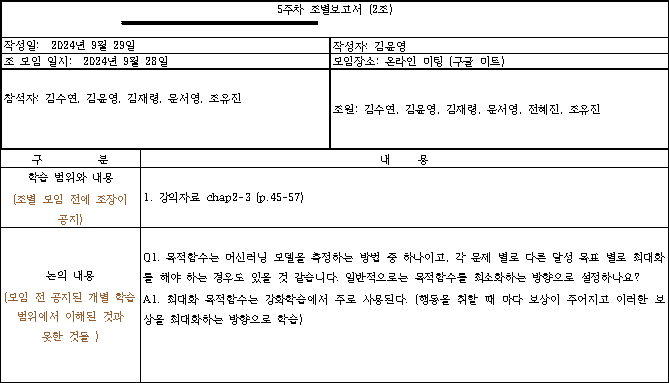

페이지 2 텍스트:
 

a. EER GSE AS ARE We 활 용 하기 어렵다고 하셨는데. 그럼 이들 해 절 할 수 있는

, 무 작 위 나 날 발 탐색 알 그 리 즘 외의 어떤 일 고 리 즘 이 있는지 궁 금 합니다

2 9571217 (Optimizer)2| wets AZ. SAL (Momentum) + ol 닫 계 의 기울기 정
Z 보들 일정 바울로 더해 엄 메 이 트 하여 정 사 하 강 범 보 |

다 더 바르게 최 적 점 에 도 달 하는 방법

- 정규화 방법 01. 18 정규화)

- 20900 (RMSProp + 2a@) © SGD Go] J

adalat gel Hes we

~ BEA Wel Simplex Method}: ae] ane E

기 위해 TEES BE ME Nese we

    

  

03. 6.5 미 1 차 도함수 [는 합 수 의 기울기, 즉 값 이 커지는 방 향 몰 지 지 함 이라고 기 재 되어 있는데
[0850 이 면 함 수 가 증 가 하는 방 향 을 지 시 하고. (1444 이 면 함 수 가 감 소 하는 방 향 올 지 시 하는 것 아닌가
대 양 수 에 대해서만 강 의 자 료 에 기 재 해 놓 았 는지 궁 금 합 니 다 > 최저가 되는 회 적 점 을 찾아야 해서 그런걸
까요!

23. 가 둘 기 가 양 수 일 정우 원 -> 오 , 음 수 일 Be goa 밤 량 으로 같이 커진다. 목 적 함 수 의 회 저 점 을 찾 |
으려면 갖 이 작 아 지는 방 향 들 찾 아 야 하기 때문에 양수. 음수 모두 가 둘 기 의 반 대 방 향 -"[4 을 사용 해 야 |
한다.

 

 

 



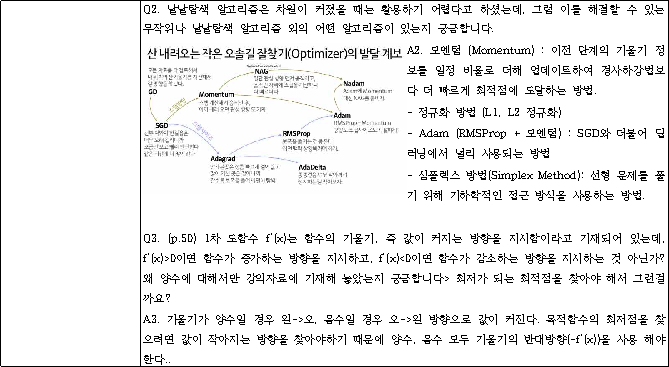

페이지 3 텍스트:
 

 

24. 예제 8-10 에 서 와 갈 이 최 저 점 이 여러 개 있는 정 우 는 알 고 리 즘 이 어떤 취 저 점 으로 선 택 하는지? 알 |
고 리 즐 이 선 턱 한 최 저 점 보다 선 택 하지 않은 최 저 점 이 더 나올 가 능 성 이 있는지?

4. 980 : 훈련 데 이 터 들 무 작 위 로 Este] Wish she we. sels] sel sage Pests 더
나은 최 초 점 을 괄 수 있게 된다. 하지만 랜 덤 으로 선 택 되기 깨 문 에 선택한 최 저 점 이 최저가 아닐 가능성
이 있다. [하지만 그런 정 우 는 드물다)

05. 500 가 290 보다 of HES | HESS 생기는 단 점 이 있을까?
65. 전역 최 적 점 [916691 400000440) 대신 지역 최 적 점 ( ㅠ 0091 880000040/ 에 같 헐 수 있다.

- 9 습 들 이 너무 크면 정 로 가 불 안 점 해져 진 동 하거나 발 산 할 수 있고. 학 습 들이 너무 작 으 면 수렴 속 도 |
가 느려진다

al ase joo) fame aria (S00)

OI sles ate su ac
wee

 

  

m8 00

  

Sabha cited ey

 

   

saa 4

 

 



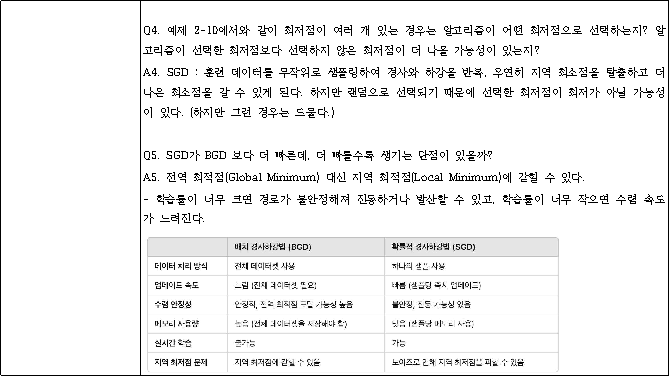

페이지 4 텍스트:
 

106. 정사 하 강 법 에서 적절한 학 습 들을 선 믹 하는 방 법 은 무 엇 인가 획 습 들을 너무 크게 아니면 작게 설 점
갔을 때 생기는 문 제 점 은 무엇일까? 그리고 학 습 들 디폴트 같이 0.01 인 이 유 가 무 엇 인가?

Ac. SSS AMSG, sels He], AS oe] SE SA SS SBE Es och /4400. 10650700'
등과 de 적 용 혐 학 승 들 일 교 리 즘 은 자 동 으로 학 슴 를 조 정 한다. ofe| oe] obleldah ced aeola}
실 엄 한 결과, 0.01 은 적당히 바른 수 렴 을 보이는 값 으로 자주 자 용 되지만, 항상 0.01 이 최 적 은 아니기 af
[ 문 에 실 험 을 콩 해 조 정 하는게 박 람 직 하다.

07. 59) CHE MSS] VAIO] 사 용 되 는 이 유 와 역 전 파 과 정 에 저의 역 할 은 무 엇 인가?

7. 다층 0 렘 드 론 은 가 중 치 가 여러 개인 합 섬 함 수 이기 때문에 미 분 할 때 연 채 법 칙 을 사 용 하며. 역 전 파 |
dol VAS SASo|N AB 은 닉 층 을 거쳐 입 력 층 까지. 각 충의 손 실 에 대한 기 울 기 를 순 차 |
적 으 로 계 산 한다. [+ 3. 절 에서 설명 예정)

08. 지역 최 적 해 가 전역 최 적 해와 매우 비 숫 한 성 능 을 내 는 가. 들의 차 이 가 큰 겸 우 는 없는가.

JAG. 함 수 가 매우 복 잠 하고 비 션 혐 적 이라면, 지역 최 적 해와 전역 최 적 해 사 이 의 성능 처 이가 클 수 있다.
그러나 간단한 함 수 냐 제약 조 건 이 많은 무 제 에서는 지역 취 적 해와 전 덕 최 적 해 사 이 의 성능 차 이 가 미
헨 일 적 으 로 전역 최 적 해 들 찾는 과 정 은 비 몽 이 많이 들거나 불가능할 수로 있다.

 

 

 



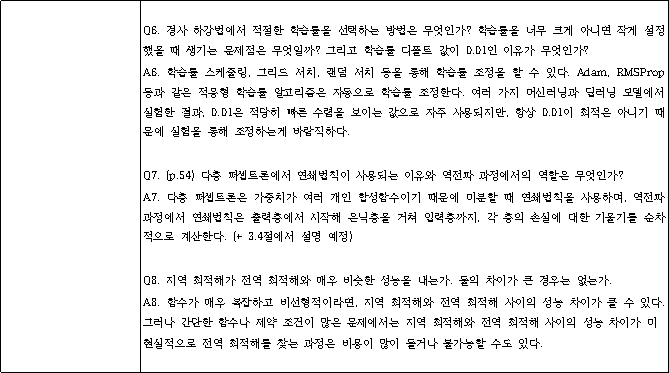

페이지 5 텍스트:
 

운 내용

 

 

키타

 

 

 



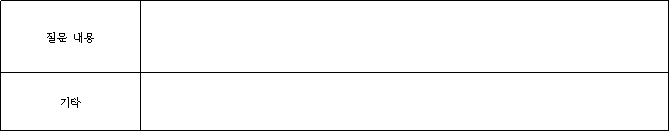

페이지 6 텍스트:
 

5 주 차 개 별 보고서 (2 조 )

 

이토 김수연 학번 202000728 학과 통계학과

 

 

 

 

 

 

<p

1) 때 개 변수 궁 간의 밤색
- 기 계 학 습 은 적절한 모델 선택, 목 적 합 수 정의, 최 적 점 탐 색 하는 전략 사용
ㅡ 특 징 궁 간 예서 해야하는 일 을 모 델 의 매 개 변수 중 간 에서 하는 일로 대 치 한 셈
~ 학 슬 모 델 의 매 캐 변 수 궁 간 은 특징 중간 보다 수 배 ~ 수 만 베 넘 음
107? 매 캐 변수 중 간 은 모 델 의 매 개 변수 개 수 에 따라 결 정 되기 때문
예 를 들어 다 총 퍼 셀 트 론 의 정우 뉴런 개 수 에 따라 가 중 치 와 바이어스 수가 증 가 하므로 매 개 변
학습 내용 수 종 간 의 차 원 이 매우 커짐
~ 최 적 해 를 탐 색 할 때 전역 최 적 해 에 가까운 지역 최 적 해 를 찾고 만 족 하는 정 우 가 많음
~ 최적화 둔 제 해결 밤 범 으로 날 날 탐 색 알고리즘, 무작위 밤색 알고리즘 등 이 있는데 전형적인 말
고 리 즘 으 로 는 독 적 할 수 가 작 아 지는 방 향 을 미 분 으로 찾아내는 방 범 이 있음

 

2) he
- 미 분 의 정의

     

feta 200
r= si 570) = fy, A Pes

 

 

 

 



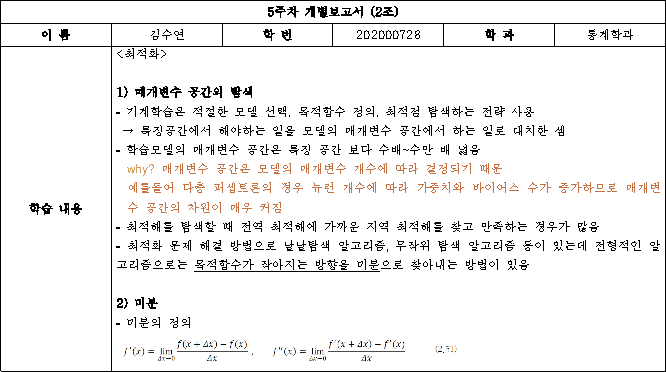

페이지 7 텍스트:
 

 

 

Dy Sass FF9 TE, = a AS FEE AT
최 저 검을 찾기 위해서는 키 울 기 의 반대 방향 즉 -/'1] 방 향 으로 가야할

~ 편미분: 변 수 가 여러 개인 합 수 의 미분 ( 미 분 값 이 이루는 벡 터 를 그 레 이 디
매 캐 변 수 의 정우 많은 변 수 가 있으므로 편 미 분 을 사용함

 

- 연 계 벌칙
AES Plas RIS Hi} gD
;
가

   

 

리 6600)0000.
「00000000

   

다 총 퍼 셉 트 론 은 합 설 합 수 이 기 때문에 연 세 빔 칙 을 적 궁합
- 야 코 비언 행 릴 (일차 미분}, 혜 시안 행 월 (이차 미분}

8) a4} ae Gale
아래 식은 정사 하 강 벌이 낮은 곳 을 찾아가는 원리

을 ( 독 적 함 수 에 태 한 기 울 기 ] 이 고 ./ 는 학 습 들 [한번에 열 마 나 이 등 할지 결정]

= 29

  

 

 



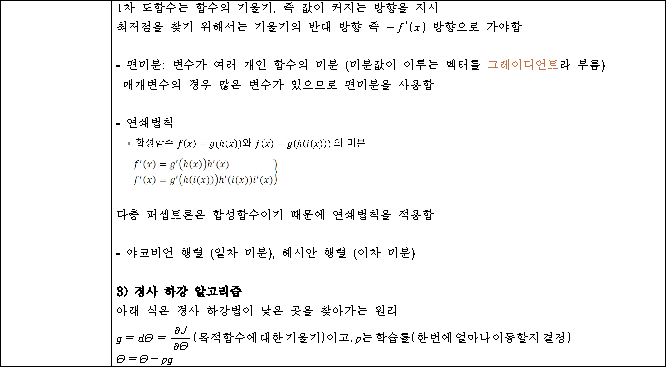

페이지 8 텍스트:
 

~ 배치 정사 하강 말 고 리즘: 샘 플 의 그 레 이 디 언 토 를 팽 글 한 푸 한 쩌 턴 에 갱신
~ 스 토 캐 스 틱 정사 하강 말 고 리즘: 한 셈 플 의 그 레 이 디 언 트 를 계 산 한 후 즉시 갱신

 

 

결 문 내용

 

1 독 적 할 수 라는 것은 머 신 러닝 모 딜 을 측 점 하는 방범 중 하 나 이 고,
르 다 보니 어떨 때에는 최 대 화 들 해야하는 정 우 도 밌 을 렌 데 일반적
방 향 으로 설 정 하나요 ?

-> 최대화 목 적 함 수 는 강 화 학 습 에서 주로 사용됨
(HSS AL of ob 보 상 이 주 어 지 고 이러한 보 상 을 최 대 화 하는 방 향 으로 학습)

 

 

 



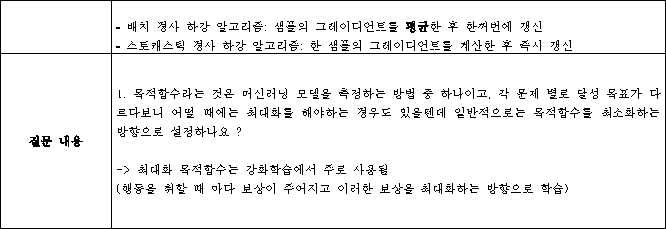

페이지 9 텍스트:
 

5 주 차 개 별 보고서 (2 조 )

 

 

 

 

 

 

 

     

ae 김은영 학번 202000872 학과 통계학과
1. 깨 개 변수 콩 간의 탐색
- 키 계 학 습 의 최적화 ㆍ 훈 련 집 함에 마라 목적 합 수 의 최저점 찾기
= Stochastic Gradient 0050006" 미니 배 치 (일부 데이터 모 음 ) 들 사 용 하여 다소 부 정 왁 할 수 있
지만. 게 산 속 도 가 빨 라 지 기에 학 습 량 증가.
- 학습 모 델 의 매 개 변수 중간 ㆍ 높은 자 원 에 비해 훈 련 짐 합의 크 키 가 작아 del asses pe
는 일은 불 가 능 합 .
new Tasa) — OUMAES SIE) HEEB IaED
° Www)
ae ae

 

tf

  

 

14964090 | | 49404
- | |
sate estes

 

700) 글 자

 

arg f(0)

- 기 계 학 습 의 목표

 

 



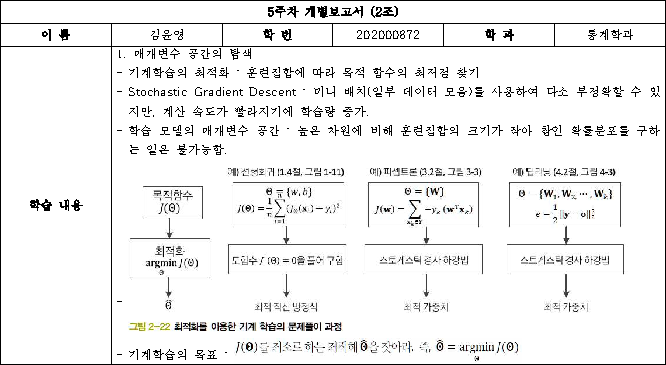

페이지 10 텍스트:
 

 

- 최적화 문제 해결
- | 날 날 탐색 알고리즘

ee oats

 

crt

geeetem aay
2998

  
 
  

의 의 기.
aR
ah

 

 

- 차 원 이 높 아 지 면 적응 불가

- 2. 무작위 탐색 알고리즘

알고리즘 =-2 무 직 위 틸 색 밀 고 리즘

 

- 아무 전 략 이 없는 알고리즘

 

 

 



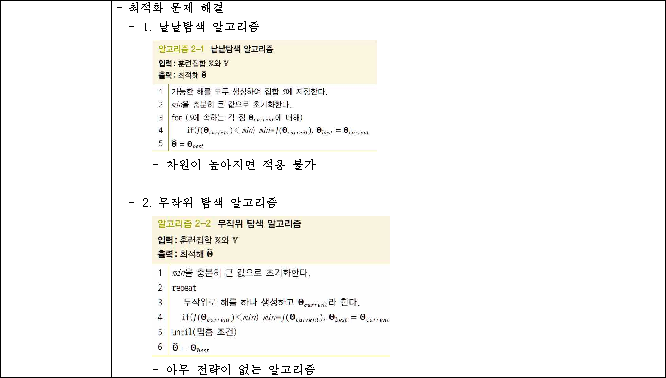

페이지 11 텍스트:
 

 

 

- 3. 키 계 학 습 이 사 용 하는 전형
일 고 리 3 2 3 71 게 락 슴 이 사 용 하

pai: Sea Rey
Bet 8

 

188
O71 So 7 SI ta FEL
e- 0148

unt

 

여 주 기 회 08 식 짐 호다.

 

 

- 미 분 을 통해 목 적 할 수 가 작 아 지는 방향 과 악

2. 미분

- 미 분 의 점 의

 

Petan— es

 

= FG) Mn

 

 

 



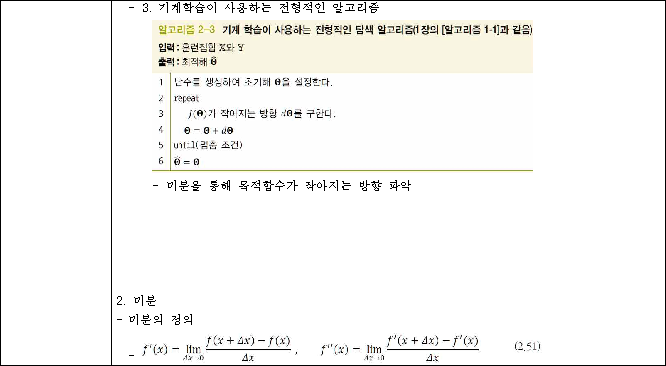

페이지 12 텍스트:
 

- 편미분 정의
wieS)sitantcteatnd |

    

1) = Foran

 

 

 

 



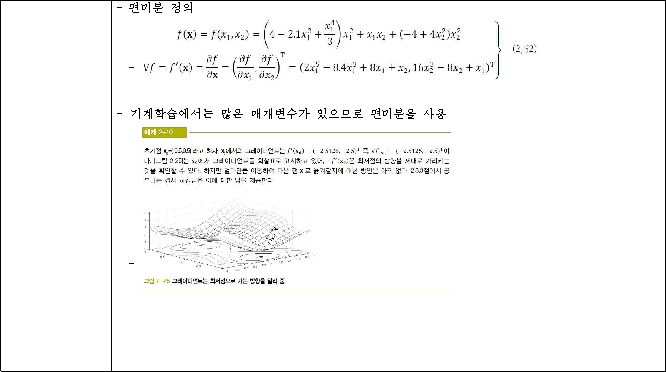

페이지 13 텍스트:
 

 

- aA ae

 

  

 

2 차 편도 합 수
ef; ef

 

 

 

 

식에서 좌 변 이 중 속 변수. 세 타 가 득 입 변 수 임

 

 

 



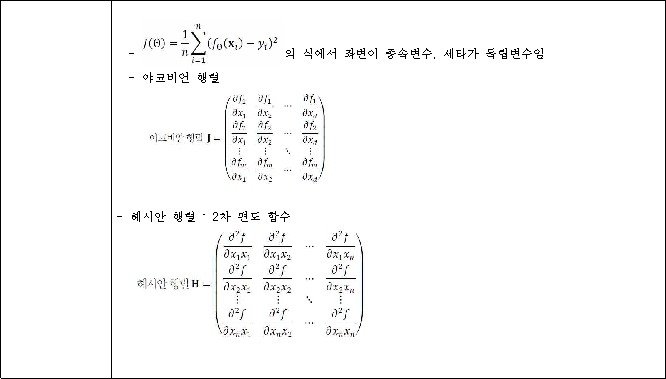

페이지 14 텍스트:
 

 

 

3. 정사 하강 알고리즘
- 배치 정사 하강 알고리즘

als 24 wal aa ag ert,

 

 

- 스 토 캐 스 틱 정사 하강 알고리즘

    

브이 이:
Joie = oR Ae

    

 

 



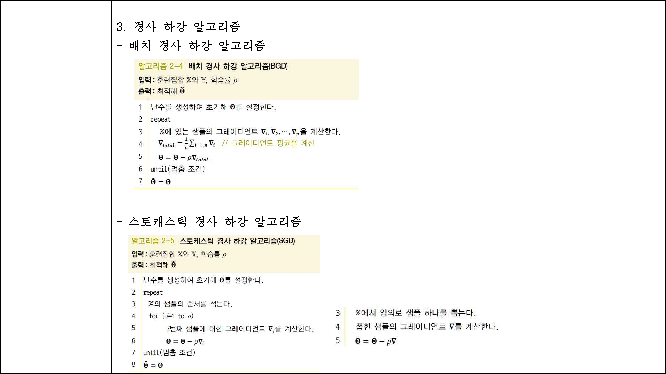

페이지 15 텍스트:
 

 

 

결 문 내용

 

- 예제 2-10 에 서 와 같이 최 저 점 이 여러 개 있는
- 정 사 하 강 별 외에 최적화 방 벌이 있는지?

정 우 는 알 고 리 즘 이 어떤 방 향 으로 진 행 되는지?

 

 



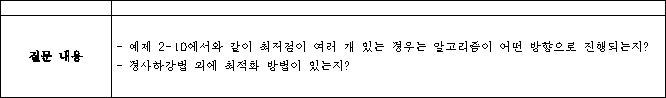

페이지 16 텍스트:
 

SHA ABRAM (2)

 

이글 ane ae 202100939 ear aaa

 

 

 

 

 

 

23 최적화 이른
Stochastic Gradient Descent
al GIO Ba 일부 데이터 모듬, 860 는 게 산 량 많 몸 , 500 는 계 산 속도 빠 음 [네미 ㆍ 65 따 |

23 매 재 쁜 수 공 간 의 탐색
늘 은 차 된 메 비해 푼 련 집 합 의 크 기 가 작아 확 들 분 포 를 구 하 | 8
theta OAKS, Jthela) BERS 일

weil MYES, gals

학습 모 럴 의 매 개 본 수 공간 : 득 징 공간!

2 가 전역 최 픽 해 메 가까운 지역

최적화 문제 해결 : 날 날 탐색 말 고 리즘

(Rewer Hone wee se OSE

argmin j(®)
°

후
따
더

  

232 미분
경사 하 감 말 고 리 즘 의 Wage - thet 로 (4 들 사 몽 한다
(Ge) BAO SBS] sy SA
편미분 : 본 수가 여 러 재인 함 수 의 미분
그 레 미 디 먼 트 는 최 저 접 를 가는 방 향 을 말 려 중
2 Abts ye bate, Wet GREW! uel NaaaM det
Sale: Geis (te Mdsee Bees)

 

 

 



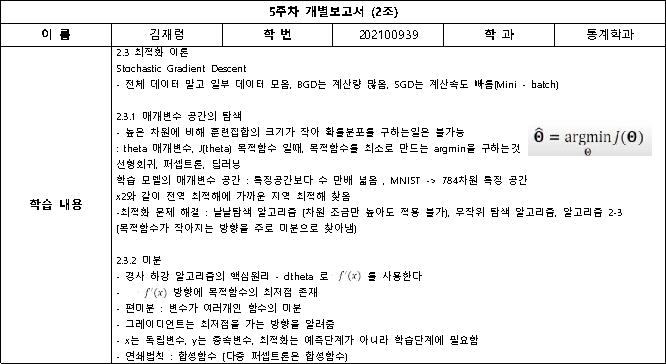

페이지 17 텍스트:
 

TRUE BE AOE, aS TS ORS

 

 

23.3 점사 하강 말 고 리즘
Bij lwo Were Note ala

배지 절사 하강 Panag: ABS] AVE Bae 루 한 꺼 본 에 갱신 @=0-&
SENAY By Oz [5001 : 한 챔 품의 그 레 이 디 언 트 을 제 산 한 후 즉시 쟁 신

 

 

 

 

 

 

질문 내용

 

Sco 가 800 보다 더 빠 른 데 , 더 빠 을 수록 생기는 단 짐 미 입 들 까 ?
폼사 하 강 벌 메 서 적절한 학 습 을 를 선 택 하는 방 법 몬 무 엇 인가? 학 습 들를 너무 크게 아니면 작게 설 정 했 을 때 싱 기 는

문 제 점 몬 무엇일까?

 

 



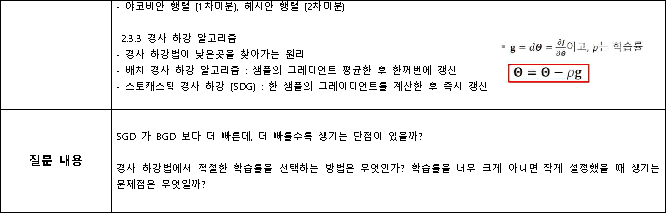

페이지 18 텍스트:
 

5 주 차 개 별 보 고서 (2 조 )

 

의 를

운 서 영 학번 202001288 학과 통계학과

 

 

 

 

 

 

학습 내용

 

10900 의
1. AS (Optimization)
공 극 적 인 목 표 는 목 직 항 수 를 회 소 와 하 이, 모 덜 이 새로운 대 이 더플 괄 여 촉 칼 수 있도록 앙 .

2 the BA) AS EC

Bab SUA dole 7} aloolsiay, Fo Ba Mele oes Weel Se SEE eyo Aol al
ag

A Yee ade Cee Mela, SAYEE Yolen, Teo ade Sue
He Hdd HE USE HG. deny Bayes dae she dalle gepop 할.

 

할 석 하여 목 적 항 수가 최저가

33S OA Mae Ae 알고리즘
D Wiest Alexnaustive search) LAE
가능한 모른 헤 를 하 나 하 나 석 다 딸 색 하의 문 제 의 최 직 리 를 하는 방법 1 관 전 랄 식 )
ale] BALES Aveo Ae] Srl vee

2 ae ed eae

a SUS Sale Beebe AME He ey, del ZEeE AES Solr Maal te AE

 

AE ave] 4a, ee AAAE gets ee eae

3) lage] epee Weel eos

 

 



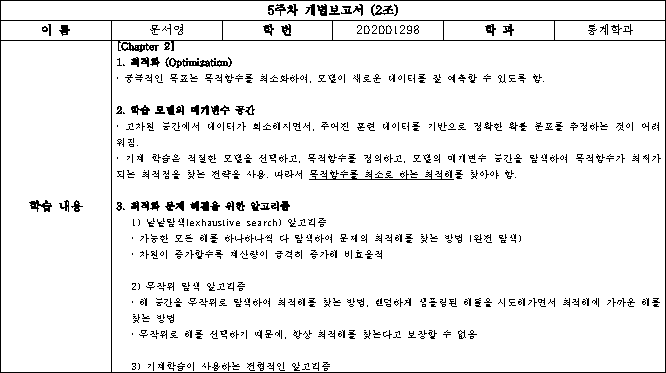

페이지 19 텍스트:
 

 

 

Sayse Hauge TE aE ETE TUTE GE TG

Sayer aeple Gea Fa lees He

OF ote 황 수 가 증 가 하는지 강 소 하는지, 즉 wel vale YE wae

Dh olge addy S89 See Soa, 2 Agel AREA Aes Fe

dO) ~/G)E Hae 9 24 ot UadEa ag we

EUS SE MIE aeldweiondenm ¥E > Aas See dake EAE GE ABA 가 변
Fobtderd det oles dee Adee aol Ba ial 사용)

4s dees Uautose wagUE tpeto oz

야 르 비 원 윌 얼 : 백터 Ee UIE Se Rye ae IU Te)

Ag dg: au 가 향 수 의 2 차 권 이 폰 몰로 구성된 성월 12 가 이콘)

4) BGDBatch Gradient Descent)

800 는 모른 폰 련 4 이 터 를 한꺼번에 사 용 하여 목적 향수 기 율 키 를 게 산 한 푸 , 한 번 에 과 라 이터 엄 미 이 트

자 올 폴 의 키 울 키 101200011 를 게 산 한 푸 , 이 키 울 키 들을 평 근 하여 한꺼번에 메 게 벤 수 를 업데이트 하는 방식

한 번의 엄 대 이 트 폴 뒤 해 전체 매 이 터 백 을 사 율 하기 문예, 정확한 기울기 계산 가능. 하지만, 건 체 데 이 터 뱃 을 사
용 하 므로 격 신 향이 매우 않아 대용량 대 이 터 펫 에 는 비 요 울적

 

5) SGD(Stochuatic Gradient Descent)

.500 는 전체 대 이 터 셋 이 아니라 각 폰 련 4 이 더 포 인 트 마다 키 울 기를 계 신 하고 자 라 이터 업 대 이 터

한 번의 업 디 이 더 콩 뒤 해 하 나 의 데이터 포 인 트 만 사용. 4 이 터 객 일부만 사 용 하 으로 미우 빠 든 업데이트 가능.
Local minimal 2Y Hee] Ya, dea AA SBE He Se.
117 꼴 풀 의 손 서

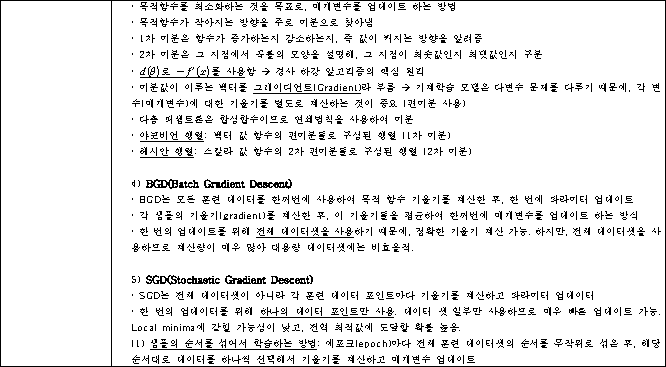

페이지 20 텍스트:
 

 

121 일 이로
dgay a Ee

IGE TG Te TSE At Sa ATTA SAY SHAE HA PEE
을 이용해 1e1E Adeha, Sa oles dacs,

 

 

 

0. Aut Gees GWA He deh Hee AES wel GOL elt Soll
BEE Lg ala) daa del Asal oe vee Use UE, Bol viet = dee GED Sood dae &
엿 이 워 는가.

 

 

 



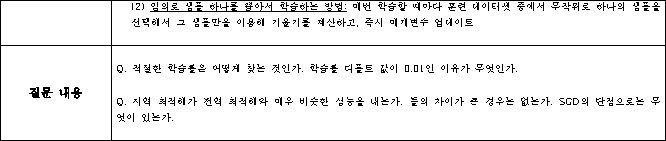

페이지 21 텍스트:
 

5 주 차 개 별 보고서 (2 조 )

 

의

 

전혜진 학번 202008098 학과 통계학과

 

 

 

 

 

학습 내용

 

 

Lola aero) ash
기게 학 슬 의 최 적 와는 단지 폰 련 집 랍 이 주 어 지 고, 폰 련 질 함에 바라 점 해지는 목 적 항 수 의 외 저 점 을 Hehe

 

 

의 스 트 케 스 틱 경사 하 강 법 1500, 5100525110 12001 00500011 | SE MLE 다 쓰지 많고, 하 나 의 데 이 터 나 작
을 데이터 목 응 만 사 용 히 서 가 중 지돌 업 미 이 트

2. 학 슴 모 렐 의 미 키 번 수 농간

WAY SES TUL Sy EU, Hast - 수 빅 만 차 릴 의 메 께 변수 능 간 으로, 전역 최 적 헤 에 가 아 운 지역 최 적 와

En dees et ae

 

 

 

 



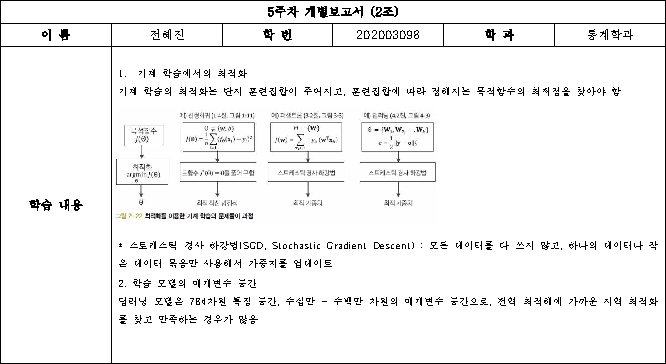

페이지 22 텍스트:
 

 

 

 

= 7A 80 HS De Se Se
» 16-220}, & 6 = areminj(@)

 

3. 미 론 에 의한 최 적 와
루 미 분 메 의한 최적화
+ algo) ae]

fete)

9 = tg hae Fo

 

Po) jn ee
! ae sae
- Sayer able yee Fe olde wend
= 9b SRF 데는 관 수 의 기 윤기, Fol AE PE ALA

- Web ra abel Saleeal Aa wol eA
case

- 번 수 가 이리 기인 항 수 의 이론

- 기게 확 승 에서 편 미 론 : 미 께 벤 수 질 합 에 많음 벤 수가 있으므로 권 이 문 을 많이 사용

 

 



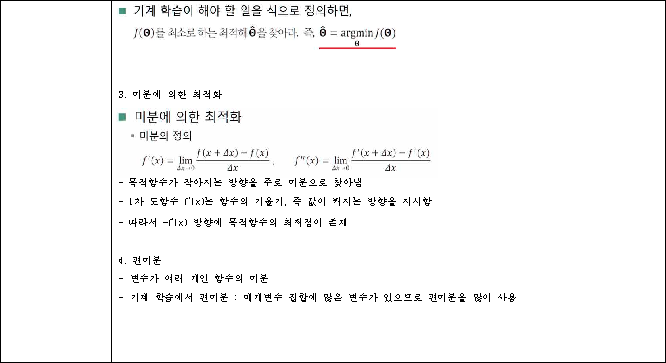

페이지 23 텍스트:
 

 

 

개어 가지 고가
Ei

 

 

이이 기려 내 |

 

5. way
= ola)

+ BABS py ~ acne Ole

 
 

won

   

00000

다층 회 엠 트 존 에 서는 출 력 값 이 일 럭 ole SE 74 GAS 받기 띠 문예 오 차 를 자 가 중 지에 DA a
하는 것이 뭘 요 하 다. 이버 가 가 중 지에 대한 미 룬 을 쿠 해야 하는대, 가 충이 앞 춤 의 결 과 에 의 즌 하고 있기 떼 문 에 1 역
dab 자 충의 가 중 지에 때 한 오 차 의 미 룬 을 쿠 하 려면 련 괴 범 칙 을 사용해야 한다

Bole
- 야 쿄 비언 영 럴 : 고자질 할 수 의 Lat Mole vs, Age gs motel Beal oA Wels

 

 



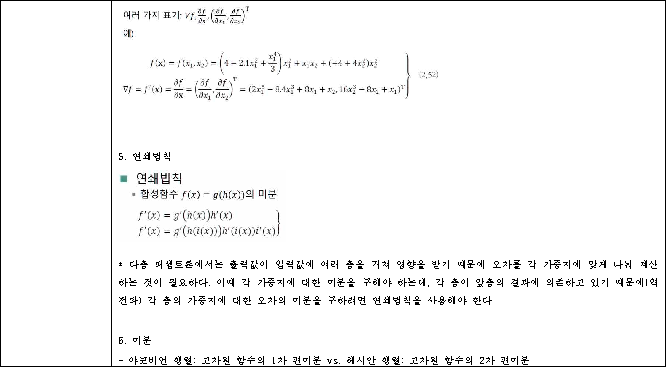

페이지 24 텍스트:
 

7. 경 사 하강 일.

듭

리즘

 

7= 이 론 방 량 으로 업 미 이 트 , = 회 소 많을 el Aad ole
헤지 경사 하강 잎 고 리 즘 : 울 풀 의 그 리 디 언 트 1 키 울 키 를 평 근 한 e ddl a

 

- 스 트 케 스 틱 경 사 하강 알고리즘 : 순 서 폴 섞어서 한 번 에 집 헤 늘고 수 생 하는 것
ex. LOO-Lel Loot el ae dake Ech

 

 

검문 내용

 

Olio SO). 차 동 황주 how WEA 1-1, 죽 기 꺼지는 방 장 을 지 시 항 이 라고 키 지 되어 외 는 대
Chorvelel Wer 증 가 하는 밀 량 을 지 시 하고, 1170<[ 이 연 광 수가 간 슨 하 는 방 생 을 지 시 하는것 아닌가?
웨 양 수 에 대해서만 강 의 자 로 에 기 지 해 농 왔는지 중 증 합 니다

> 외 서 가 되는 외 적 점 을 핫 아야 해서 그 런 킬 아요?

'0210.54) 다 춤 떠 켈 트 론 에서 연 왜 법 칙 이 사 용 되 는 이 유 와 역 컨 과 과 정 에 서 의 역 할 은 무 엇 인가요?

 

 



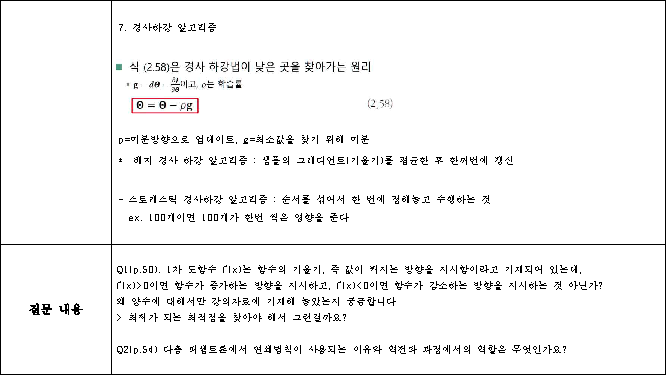

페이지 25 텍스트:
 

BEA 개 벌 보고서 (2 조 )

 

 

 

 

 

 

 

의 를 조유진 학번 202103300 학과 통계학과
2.3 최적화
2.3.1 매 캐 변수 중 간 의 탐색
- 학습 모 델 의 매 개 변수 종간
wouseay 에 34: 개비.
기
최적화 . .
학습 내용 키비) ere=op gore] | astaten zit |

     

   

      

| | |

porren 0

 

그 2772 30 018 74 wmgO a
최 적 화 는 1(01010) 들 최초로 하는 최 적 해 대 010.10「 을 찾는 Mlargmin Ieheta))

- 최적화 문제 해결
날 날 탐 색 10100045470 50「 대 ) 알고리즘" 가능한 a SF Ade Ge Sol dF minds 총
분 히 큰 2S ABH A, current 01008 가 011 보 다 작 으 면 I thetakS AAA thetaz
갱 신 하는 알고리즘. 단 , 차 원 이 조금만 높 아 져 도 적응 불가능.

 

 

2 무 작 위 탐색 알고리즘" 111 을 출 분 히 큰 dee Ade 뒤 . 무 작 위 로 해 들 하나 생 성 하고

 

 



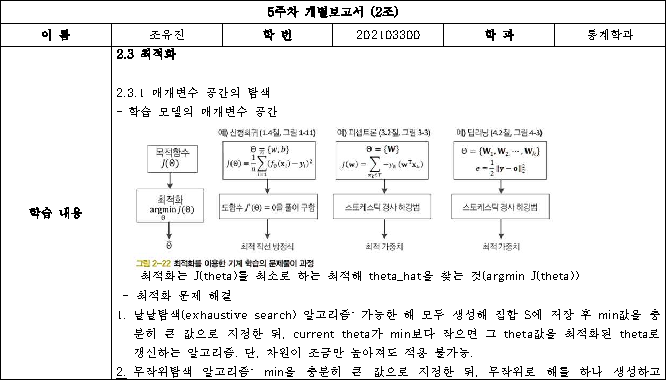

페이지 26 텍스트:
 

 

 

current theta} rin Bae, (Heo
독 적 할 수 가 작 아 지는 방 향 을 주로 미 분 으로 찾아내는 것

2.3.2 미분

- 미 분 에 의한 최적화

UF S84 Foe 함 수 의 키 울 키 , 즉 값 이 커지는 방 향 을 지 시 함

ㅡ 따라서 - 00 방 향 에 독 적 합 수 의 최저점 존재 140 로 -『 00 들 사용할 - 경 사 하강 알 고 리 즘 의

aa de
- 편미분

변 수 가 여러 개인 함 수 의 미분.
- dag

합 성 함수 100) = 00000) 의 미분. 다 충 퍼 셉 트 론 은 합 설 할 수 이므로, 0404 의 가중치 갱 신 할 때 연
Aaa 42. Gad oF Gade aay

- auld ve

de fe UF veel 얻은 Ye 행 훨 식 의 기하학적 의 미 에서는 행 혈 식음 선 형 변 환 할 때 단위
면 적 이 열 마 만 클 늘 어 나 는 가를 나 타 님.

 

 



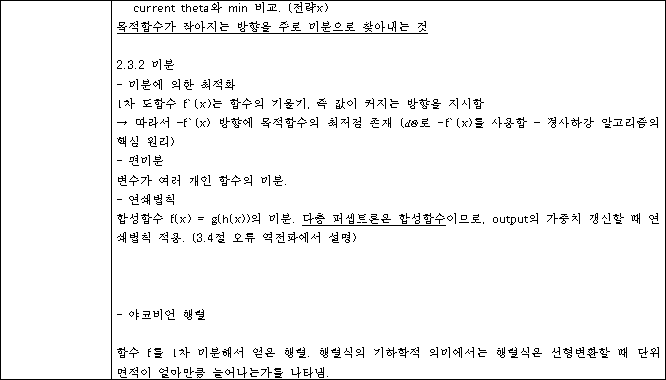

페이지 27 텍스트:
 

 

 

 

 

- 혜 시안 행 월
2 차 편 도 할수 ae.
a 그

ar
00 — [Fearn

 

ay 기
Bends Badr

 

 

or
on

of
de
ag
Be

 

 



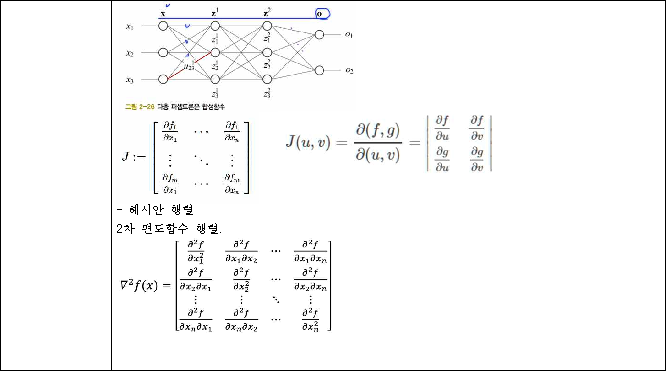

페이지 28 텍스트:
 

2.3.3 정사 하강 알고리즘
키 계 학 습 에 서 의 최 적 화 는 단지 훈 련 짐 합 이 주 어 지 고, 훈 련 짐 함에 따라 정 해 지 는 독 적 할 수 의 최저
지 점 을 찾는 것.

+g=do= HOD, pe HSE

O=0~pg

~ SEA TTHUACrachastic Gradient Descend” & $Ee] gradioS Ake 푸 즉시 갱신
+ GDS AM aolelBatcnvt ha QF alelelal SEMini-Batems Gace we. 4E7b
BGDEO WE. Local 400108 에 빠지지 않고 61081 Minimal FO 가 능 설이 더 놀음.

- 배치 정사 하강 알 고 리 08060)" 샘 플 의 8140101 를 펼 균 한 푸 한꺼번에 갱신

 

 

 

 

 

 

질문 내용

 

및 날 날 탐 색 알 고 리 즘 은 차 원 이 커 졌 을 때는 활 용 하키 어 렴 다고 하셨는데, 그럼 이들 해결할 수

착 위나 날 날 탐색 알고리즘 외의 어떤 알 고 리 즘 이 있는지 궁 금 합니다.

 

 



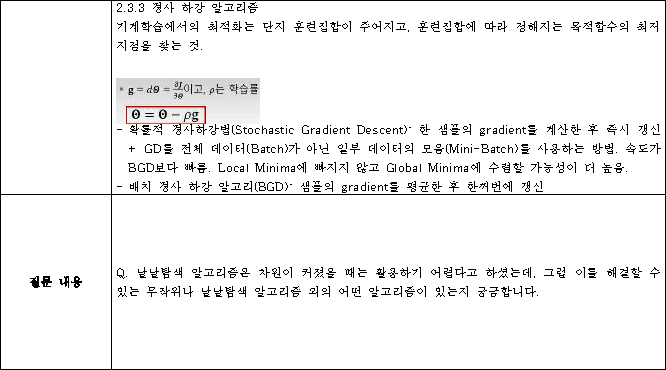

In [22]:
import pdfplumber
import pytesseract
import cv2
import numpy as np
from google.colab.patches import cv2_imshow  # Colab에서 이미지 표시용

# 이미지 파일로 변환하는 함수
def pdf_page_to_image(pdf_path, page_number):
    with pdfplumber.open(pdf_path) as pdf:
        page = pdf.pages[page_number]
        # 페이지를 PIL 이미지로 변환
        pil_image = page.to_image().original
        # PIL 이미지를 NumPy 배열로 변환
        return np.array(pil_image)

# 텍스트 추출 함수
def extract_text_from_image(image):
    # OCR을 통해 텍스트 추출
    return pytesseract.image_to_string(image, lang='eng+kor')  # 영어와 한국어 설정

# 이미지에서 테이블 및 이미지 탐지 함수
def detect_images_and_tables(image):
    # OpenCV를 사용하여 이미지 처리
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)  # RGB로 변환해야 함
    _, thresh = cv2.threshold(gray, 150, 255, cv2.THRESH_BINARY_INV)

    # 이미지에서 테이블 영역 탐지
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    images_detected = []
    tables_detected = []

    for contour in contours:
        # 사각형 형태의 영역 필터링
        area = cv2.contourArea(contour)
        if area > 1000:  # 최소 면적 기준
            x, y, w, h = cv2.boundingRect(contour)
            # 이미지로 잘라내기
            img_crop = image[y:y+h, x:x+w]
            images_detected.append(img_crop)

    return images_detected, tables_detected  # 현재는 테이블 탐지 기능 구현 중

# 메인 함수
def main(pdf_path):
    with pdfplumber.open(pdf_path) as pdf:
        for page_number in range(len(pdf.pages)):
            # PDF 페이지를 이미지로 변환
            image = pdf_page_to_image(pdf_path, page_number)

            # 이미지에서 텍스트 추출
            text = extract_text_from_image(image)
            print(f"페이지 {page_number + 1} 텍스트:\n{text}")

            # 이미지에서 테이블 및 이미지 탐지
            images_detected, tables_detected = detect_images_and_tables(image)

            # 이미지가 탐지된 경우 출력
            for idx, img in enumerate(images_detected):
                cv2_imshow(img)  # Colab에서 이미지 출력
                cv2.waitKey(0)  # 키 입력 대기, Colab에서는 필요하지 않음

# 실행
pdf_path = "기계학습 2조 5주차 조별보고서.pdf"  # 분석할 PDF 파일 경로
main(pdf_path)

- 성능이 너무 안 좋음. 이미지 화질의 문제?